In [1]:
# 0 define backend
import sys, os, time

# %env DDE_BACKEND=tensorflow.compat.v1
# %env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf

os.environ['DDE_BACKEND'] = "pytorch" # v2
# /usr/local/home/cyan3/miniforge/pkgs/cudatoolkit-11.7.0-hd8887f6_10/lib/libdevice.10.bc
# os.environ['CUDA_HOME'] = '/usr/local/home/cyan3/miniforge/pkgs/cudatoolkit-11.7.0-hd8887f6_10/bin'
os.environ['CUDA_HOME'] = '/usr/local/home/cyan3/miniforge/pkgs/cudatoolkit-11.3.1-h2bc3f7f_2/bin'
# /usr/local/home/cyan3/miniforge/pkgs/cudatoolkit-11.3.1-h2bc3f7f_2/lib/libdevice.10.bc
# https://stackoverflow.com/questions/68614547/tensorflow-libdevice-not-found-why-is-it-not-found-in-the-searched-path
# this directory has /nvvm/libdevice/libdevice.10.bc

print(os.environ['DDE_BACKEND'])

pytorch


In [2]:
# import tensorflow as tf
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     print(device)

import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
torch.cuda.set_device(0)

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')

import deepxde as dde
import numpy as np
from numpy import linalg as LA
import math

import matplotlib.pyplot as plt
import pylab

from os.path import dirname, join as pjoin

from scipy import stats
import scipy.io
from scipy.stats import truncnorm, norm
from scipy.optimize import linprog
from scipy import sparse
from scipy.stats import multivariate_normal

if dde.backend.backend_name == "pytorch":
    exp = dde.backend.torch.exp
else:
    from deepxde.backend import tf

    exp = tf.exp
    
import cvxpy as cp
import numpy as np
import tensorflow as tf
from scipy.linalg import solve_discrete_are
from scipy.linalg import sqrtm

# from cvxpylayers.tensorflow.cvxpylayer import CvxpyLayer
from cvxpylayers.torch import CvxpyLayer



print(time.time())

Using backend: pytorch



True
1
NVIDIA RTX A2000 Laptop GPU
11.3
True
0


2022-09-11 10:14:15.163401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 10:14:15.370880: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-11 10:14:15.454466: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-11 10:14:16.021871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1662916456.7189057


In [3]:
N = nSample = 100

# must be floats
state_min = 0.0
state_max = 6.0

j1, j2, j3 =1,1,2 # axis-symmetric case
q_statepenalty_gain = 0 # 0.5

T_0=0. #initial time
T_t=200. #Terminal time

print(time.time())

1662916467.2237926


In [4]:
x_T = np.transpose(np.linspace(state_min, state_max, N))
y_T = np.transpose(np.linspace(state_min, state_max, N))
z_T = np.transpose(np.linspace(state_min, state_max, N))
x_T=x_T.reshape(len(x_T),1)
y_T=y_T.reshape(len(y_T),1)
z_T=z_T.reshape(len(z_T),1)

print(time.time())

1662916467.7062387


In [5]:
def pdf1d(x, mu, sigma):
    a, b = (state_min - mu) / sigma, (state_max - mu) / sigma
    rho_x=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)

    # do NOT use gaussian norm, because it is only area=1
    # from -inf, inf, will not be for finite state/grid
    # rho_x = norm.pdf(x, mu, sigma)
    return rho_x

def boundary(_, on_initial):
    return on_initial

print(time.time())

1662916468.369931


In [6]:
x_grid = np.transpose(np.linspace(state_min, state_max, nSample))
y_grid = np.transpose(np.linspace(state_min, state_max, nSample))
[X,Y] = np.meshgrid(x_grid,x_grid)
C = (X - Y)**2

# cvector = C.flatten('F')
cvector = C.reshape(nSample**2,1)

A = np.concatenate(
    (
        np.kron(
            np.ones((1,nSample)),
            sparse.eye(nSample).toarray()
        ),
        np.kron(
            sparse.eye(nSample).toarray(),
            np.ones((1,nSample))
        )
    ), axis=0)
# 2*nSample

print(cvector.shape)
print(A.shape)

(10000, 1)
(200, 10000)


In [7]:
# 1d linprog example

rho_0_1d=pdf1d(x_T, 5.0, 1.0).reshape(len(x_T),1)
rho_T_1d=pdf1d(x_T, 4.0, 1.0).reshape(len(x_T),1)

rho_0_1d = np.where(rho_0_1d < 0, 0, rho_0_1d)
rho_0_1d = rho_0_1d / np.sum(np.abs(rho_0_1d))

# rho_0_1d_trapz = np.trapz(rho_0_1d, axis=0)[0]
# rho_0_1d = rho_0_1d / rho_0_1d_trapz
# rho_0_1d_trapz = np.trapz(rho_0_1d, axis=0)
# print("rho_0_1d_trapz=",rho_0_1d_trapz)

rho_T_1d = np.where(rho_T_1d < 0, 0, rho_T_1d)
rho_T_1d = rho_T_1d / np.sum(np.abs(rho_T_1d))

# rho_T_1d_trapz = np.trapz(rho_T_1d, axis=0)[0]
# rho_T_1d = rho_T_1d / rho_T_1d_trapz
# rho_T_1d_trapz = np.trapz(rho_T_1d, axis=0)
# print("rho_T_1d_trapz=",rho_T_1d_trapz)

rho_0 = rho_0_1d
rho_T = rho_T_1d

print(time.time())

1662916473.8274517


In [8]:
res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((rho_0, rho_T), axis=0),
    bounds=[(0, np.inf)],
    options={"disp": True}
)
print(res.fun)

Running HiGHS 1.2.2 [date: 2022-08-26, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
0.6318734471629914
Presolving model
200 rows, 10000 cols, 20000 nonzeros
199 rows, 10000 cols, 19900 nonzeros
Presolve : Reductions: rows 199(-1); columns 10000(-0); elements 19900(-100)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 199(1.99666) 0s
       2699     6.3187344716e-01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2699
Objective value     :  6.3187344716e-01
HiGHS run time      :          0.10


In [9]:
# Define and solve the CVXPY problem.
x = cp.Variable(
    cvector.shape[0],
    nonneg=True
)
prob = cp.Problem(
    cp.Minimize(cvector.T @ x),
    [
        A @ x == np.concatenate((
            rho_0,
            rho_T
        ), axis=0).reshape(-1),
        # do NOT specify bounds constraints here
    ],
)
prob.solve(verbose=False)

# Print result.
print("\nThe optimal value is", prob.value)

# print("A dual solution is")
# print(prob.constraints[0].dual_value)


The optimal value is 0.6318734626810212


In [8]:
# Define and solve the CVXPY problem.
x = cp.Variable(
    cvector.shape[0],
    nonneg=True
)
pred = cp.Parameter((A.shape[0],))
problem = cp.Problem(
    cp.Minimize(cvector.T @ x),
    [
        A @ x == pred,
    ],
)
assert problem.is_dpp()
cvxpylayer = CvxpyLayer(
    problem,
    parameters=[pred],
    variables=[x])

print(time.time())

1662916480.7724204


In [33]:
# rho_0_tensor = tf.constant(rho_0, shape=(100,))
rho_0_tensor = torch.from_numpy(
    rho_0.reshape(-1)
).requires_grad_(False)

cvector_tensor = torch.from_numpy(
    cvector.reshape(-1)
).requires_grad_(False)


rho_I=pdf1d(x_T, 4.0, 1.0).reshape(len(x_T),1)
rho_I = np.where(rho_I < 0, 0, rho_I)
rho_I = rho_I / np.sum(np.abs(rho_I))
rho_I = rho_I.reshape((100,))

# y_pred = tf.Variable(tf.zeros((100,), tf.double))
# y_pred = tf.Variable(rho_I, shape=(100,))
# this MUST be tf.Variable to get a gradient w.r.t
y_pred = torch.from_numpy(rho_I).requires_grad_(True)

print(time.time())

1662919073.11003


In [34]:
# to sanity check that backwards on cvxpy Parameter works on cpu
rho_0_tensor = rho_0_tensor.to(cpu)
cvector_tensor = cvector_tensor.to(cpu)
y_pred = y_pred.to(cpu)

# print(y_pred.numpy())
print(type(y_pred))

print(time.time())

y_pred.grad = None

param = torch.cat((rho_0_tensor, y_pred), 0)
print(type(param))

s = time.time()
x_sol, = cvxpylayer(param)
print("cpu dt: ", time.time() - s)

wass_dist1 = torch.matmul(cvector_tensor, x_sol)
print("wass_dist1=", wass_dist1)
wass_dist1.backward()
print(y_pred.grad)

<class 'torch.Tensor'>
1662919075.6208153
<class 'torch.Tensor'>
cpu dt:  55.81674122810364
wass_dist1= tensor(0.6330, device='cpu', dtype=torch.float64, grad_fn=<DotBackward0>)
tensor([-70.2294, -59.9991, -47.2306, -31.3524, -11.6804,  -1.8298,  -1.9436,
         -2.0575,  -2.1714,  -2.2852,  -2.3991,  -2.5129,  -2.6267,  -2.7405,
         -2.8542,  -2.9680,  -3.0817,  -3.1954,  -3.3090,  -3.4227,  -3.5364,
         -3.6500,  -3.7637,  -3.8773,  -3.9909,  -4.1045,  -4.2180,  -4.3315,
         -4.4451,  -4.5586,  -4.6721,  -4.7856,  -4.8991,  -5.0125,  -5.1260,
         -5.2395,  -5.3529,  -5.4663,  -5.5796,  -5.6929,  -5.8062,  -5.9195,
         -6.0327,  -6.1460,  -6.2593,  -6.3725,  -6.4858,  -6.5991,  -6.7123,
         -6.8259,  -6.9322,  -7.0382,  -7.1443,  -7.2503,  -7.3564,  -7.4625,
         -7.5685,  -7.6746,  -7.7808,  -7.8869,  -7.9930,  -8.0991,  -8.2053,
         -8.3115,  -8.4178,  -8.5169,  -8.6159,  -8.7149,  -8.8138,  -8.9128,
         -9.0118,  -9.1108,  -9.2026,  -9.

In [35]:
# to sanity check that backwards on cvxpy Parameter works on gpu / cuda
rho_0_tensor = rho_0_tensor.to(cuda0)
cvector_tensor = cvector_tensor.to(cuda0)
y_pred = y_pred.to(cuda0)

# when using cuda0, need this to get non-None grad
y_pred.retain_grad()

# print(y_pred.numpy())
print(type(y_pred))

print(time.time())

y_pred.grad = None

param = torch.cat((rho_0_tensor, y_pred), 0)
print(type(param))

s = time.time()
x_sol, = cvxpylayer(param)
print("cuda dt: ", time.time() - s)

wass_dist1 = torch.matmul(cvector_tensor, x_sol)
print("wass_dist1=", wass_dist1)
wass_dist1.backward()
print(y_pred.grad)

<class 'torch.Tensor'>
1662919173.7651596
<class 'torch.Tensor'>
cuda dt:  56.07662630081177
wass_dist1= tensor(0.6330, dtype=torch.float64, grad_fn=<DotBackward0>)
tensor([-70.2294, -59.9991, -47.2306, -31.3524, -11.6804,  -1.8298,  -1.9436,
         -2.0575,  -2.1714,  -2.2852,  -2.3991,  -2.5129,  -2.6267,  -2.7405,
         -2.8542,  -2.9680,  -3.0817,  -3.1954,  -3.3090,  -3.4227,  -3.5364,
         -3.6500,  -3.7637,  -3.8773,  -3.9909,  -4.1045,  -4.2180,  -4.3315,
         -4.4451,  -4.5586,  -4.6721,  -4.7856,  -4.8991,  -5.0125,  -5.1260,
         -5.2395,  -5.3529,  -5.4663,  -5.5796,  -5.6929,  -5.8062,  -5.9195,
         -6.0327,  -6.1460,  -6.2593,  -6.3725,  -6.4858,  -6.5991,  -6.7123,
         -6.8259,  -6.9322,  -7.0382,  -7.1443,  -7.2503,  -7.3564,  -7.4625,
         -7.5685,  -7.6746,  -7.7808,  -7.8869,  -7.9930,  -8.0991,  -8.2053,
         -8.3115,  -8.4178,  -8.5169,  -8.6159,  -8.7149,  -8.8138,  -8.9128,
         -9.0118,  -9.1108,  -9.2026,  -9.2943,  -9.386

(iter 0) loss: 1.44756 
(iter 1) loss: 1.44285 
(iter 2) loss: 1.43401 
(iter 3) loss: 1.42093 
(iter 4) loss: 1.40527 
(iter 5) loss: 1.38592 
(iter 6) loss: 1.3664 
(iter 7) loss: 1.34757 
(iter 8) loss: 1.32758 
(iter 9) loss: 1.30595 
(iter 10) loss: 1.28228 
(iter 11) loss: 1.25629 
(iter 12) loss: 1.22718 
(iter 13) loss: 1.19548 
(iter 14) loss: 1.1638 
(iter 15) loss: 1.13183 
(iter 16) loss: 1.10071 
(iter 17) loss: 1.07389 
(iter 18) loss: 1.04922 
(iter 19) loss: 1.0255 
(iter 20) loss: 1.0046 
(iter 21) loss: 0.986741 
(iter 22) loss: 0.969629 
(iter 23) loss: 0.954039 
(iter 24) loss: 0.940507 
(iter 25) loss: 0.92855 
(iter 26) loss: 0.918468 
(iter 27) loss: 0.909959 
(iter 28) loss: 0.902737 
(iter 29) loss: 0.896589 
(iter 30) loss: 0.891334 
(iter 31) loss: 0.886808 
(iter 32) loss: 0.882901 
(iter 33) loss: 0.879502 
(iter 34) loss: 0.876534 
(iter 35) loss: 0.873927 
(iter 36) loss: 0.871631 
(iter 37) loss: 0.869598 
(iter 38) loss: 0.867792 
(iter 39) loss: 0.8661

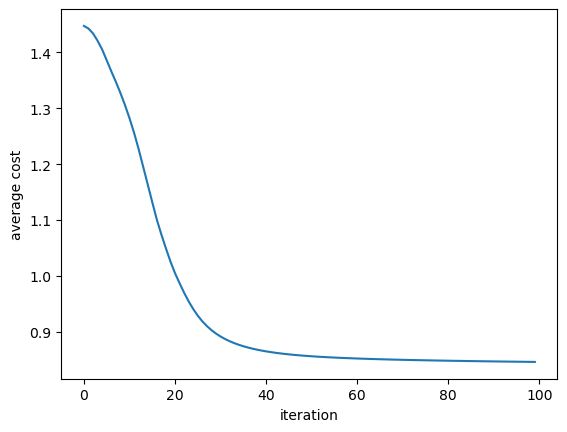

In [1]:
import cvxpy as cp
import numpy as np
import torch
from scipy.linalg import solve_discrete_are
from scipy.linalg import sqrtm

from cvxpylayers.torch import CvxpyLayer

# torch.cuda.set_device(0)

# torch.cuda.set_device('cpu')

# Generate data
torch.manual_seed(1)
np.random.seed(1)

n = 2
m = 3

A = np.eye(n) + 1e-2 * np.random.randn(n, n)
B = 1e-2 / 3 * np.random.randn(n, m)
Q = np.eye(n)
R = np.eye(m)

# Compute LQR control policy
P_lqr = solve_discrete_are(A, B, Q, R)
P = R + B.T@P_lqr@B
P_sqrt_lqr = sqrtm(P)

# Construct CVXPY problem and layer
x_cvxpy = cp.Parameter((n, 1))
P_sqrt_cvxpy = cp.Parameter((m, m))
P_21_cvxpy = cp.Parameter((n, m))
q_cvxpy = cp.Parameter((m, 1))

u_cvxpy = cp.Variable((m, 1))
y_cvxpy = cp.Variable((n, 1))

objective = .5 * cp.sum_squares(P_sqrt_cvxpy @ u_cvxpy) + x_cvxpy.T @ y_cvxpy + q_cvxpy.T @ u_cvxpy
problem = cp.Problem(cp.Minimize(objective), [cp.norm(u_cvxpy) <= 1, y_cvxpy == P_21_cvxpy @ u_cvxpy])
assert problem.is_dpp()
policy = CvxpyLayer(
    problem,
    [x_cvxpy, P_sqrt_cvxpy, P_21_cvxpy, q_cvxpy],
    [u_cvxpy])

import matplotlib.pyplot as plt

def train(iters):
    # Initialize with LQR control lyapunov function
    P_sqrt = torch.from_numpy(P_sqrt_lqr).requires_grad_(True)
    P_sqrt.to(torch.float32)
    
    P_21 = torch.from_numpy(A.T @ P_lqr @ B).requires_grad_(True)
    
    P_sqrt.to(cuda0)
    P_21.to(cuda0)

    q = torch.zeros((m, 1), dtype=torch.float32, requires_grad=True, device=cuda0)
    variables = [P_sqrt, P_21, q]
    A_tch, B_tch, Q_tch, R_tch = map(torch.from_numpy, [A, B, Q, R])
    
    A_tch = A_tch.to(cuda0)
    A_tch = A_tch.to(torch.float32)
    B_tch = B_tch.to(cuda0)
    B_tch = B_tch.to(torch.float32)
    Q_tch = Q_tch.to(cuda0)
    Q_tch = Q_tch.to(torch.float32)
    R_tch = R_tch.to(cuda0)
    R_tch = R_tch.to(torch.float32)

    def g(x, u):
        return (x.t() @ Q_tch @ x + u.t() @ R_tch @ u).squeeze()

    def evaluate(x0, P_sqrt, P_21, q, T):
        x = x0
        x = x.to(cuda0)
        cost = 0.
        for _ in range(T):
            P_sqrt = P_sqrt.to(cuda0)
            P_sqrt = P_sqrt.to(torch.float32)
            P_21 = P_21.to(cuda0)
            P_21 = P_21.to(torch.float32)
            q = q.to(cuda0)
            q = q.to(torch.float32)

            u, = policy(x, P_sqrt, P_21, q)
            cost += g(x, u) / T
            x = A_tch @ x + B_tch @ u + .2 * torch.randn((n, 1), device=cuda0)
        return cost

    def eval_loss(N=8, T=25):
        return sum([
            evaluate(
                torch.zeros((n, 1), device=cuda0),
                P_sqrt,
                P_21,
                q,
                T=T
            )
            for _ in range(N)
        ]) / N

    results = []
    optimizer = torch.optim.SGD(variables, lr=.02, momentum=.9)
    for i in range(iters):
        # use same seeds each iteration to get pretty training plot
        torch.manual_seed(1)
        np.random.seed(1)
        optimizer.zero_grad()
        loss = eval_loss()
        loss.backward()
        optimizer.step()
        results.append(loss.item())
        print("(iter %d) loss: %g " % (i, results[-1]))
    return results


results = train(iters=100)

plt.figure()
plt.plot(results)
plt.xlabel('iteration')
plt.ylabel('average cost')
plt.savefig("adp.pdf")
plt.show()